<a href="https://colab.research.google.com/github/Rishi-R-h150/SignDetecto/blob/main/SignDetecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Description of the Sign-Language MNIST Problem (American Sign Language)**

American Sign Language (ASL) is a complete, natural language that has the same linguistic properties as spoken languages, with grammar that differs from English. ASL is expressed by movements of the hands and face. It is the primary language of many North Americans who are deaf and hard of hearing, and is used by many hearing people as well. The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity.
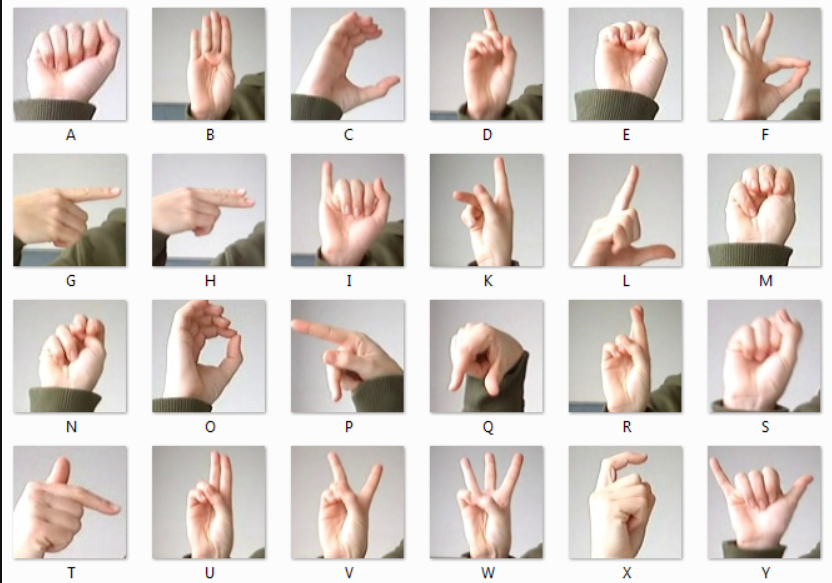

In [ ]:
!pip install kagglehub
import kagglehub
sign_language_mnist_path = kagglehub.dataset_download('datamunge/sign-language-mnist')


100%|██████████| 62.6M/62.6M [00:00<00:00, 240MB/s]

Extracting files...


In [ ]:
print(sign_language_mnist_path)

/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1


In [ ]:
import os
for dirname, _, filenames in os.walk(sign_language_mnist_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/american_sign_language.PNG
/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/amer_sign2.png
/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/sign_mnist_train.csv
/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/sign_mnist_test.csv
/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/amer_sign3.png
/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/sign_mnist_train/sign_mnist_train.csv
/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/sign_mnist_test/sign_mnist_test.csv


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import numpy as np
import pandas as pd



In [ ]:
train_df = pd.read_csv("/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("/root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1/sign_mnist_test/sign_mnist_test.csv")

In [ ]:
train_df.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784  
0       206       204       203       202  
1       175       103       135       149  
2       198       195       194       195  
3       225       222       229       163  
4       157       163       164       179  

[5 rows x 785 columns]

In [ ]:
y = test_df['label']
print(y)

0        6
1        5
2       10
3        0
4        3
        ..
7167     1
7168    12
7169     2
7170     4
7171     2
Name: label, Length: 7172, dtype: int64


<Axes: ylabel='count'>

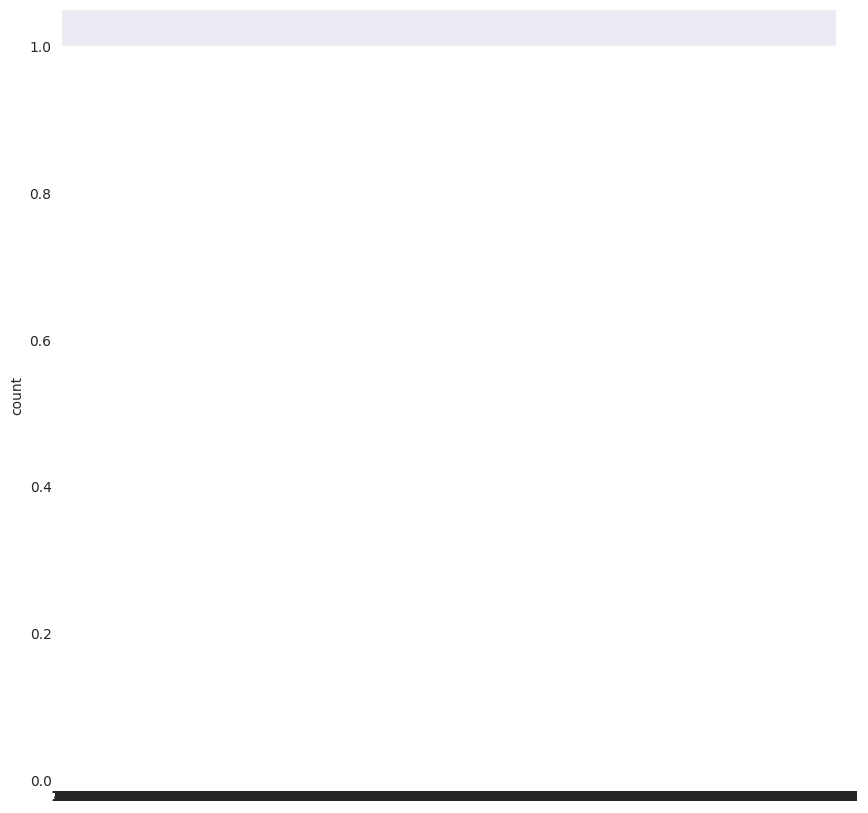

In [ ]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df['label'])

In [ ]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [ ]:
x_train = train_df.values
x_test = test_df.values

In [ ]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

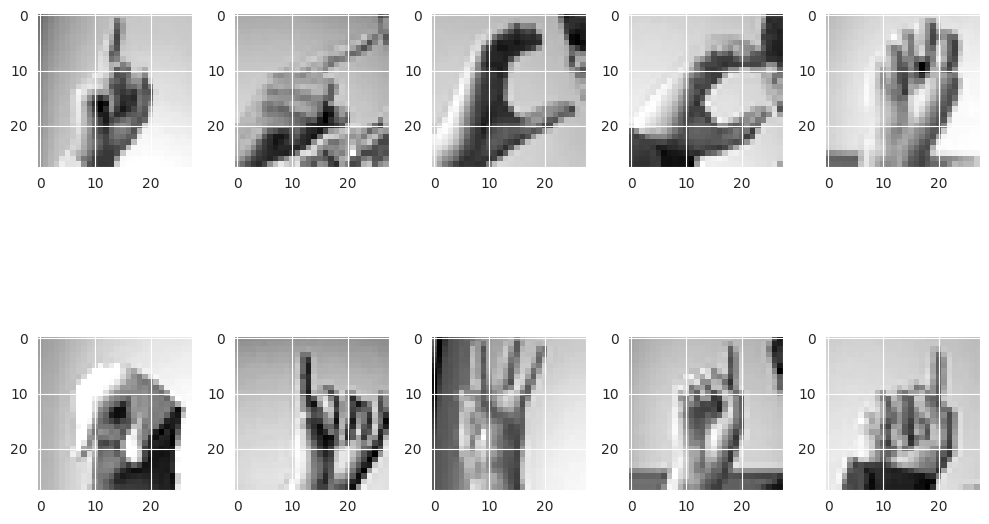

In [ ]:
f, ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

# **Data Augmentation**
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.



In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees Randomly Zoom by 10% some training images Randomly shift images horizontally by 10% of the width Randomly shift images vertically by 10% of the height I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify.

Once our model is ready, we fit the training dataset .



**CONVOLUTIONAL NEURAL NETWORKS**

A Convolutional Neural Network is a special type of an Artificial Intelligence implementation which uses a special mathematical matrix manipulation called the convolution operation to process data from the images.

A convolution does this by multiplying two matrices and yielding a third, smaller matrix.
The Network takes an input image, and uses a filter (or kernel) to create a feature map describing the image.
In the convolution operation, we take a filter (usually 2x2 or 3x3 matrix ) and slide it over the image matrix. The coresponding numbers in both matrices are multiplied and and added to yield a single number describing that input space. This process is repeated all over the image.This working can be seen in the following figure
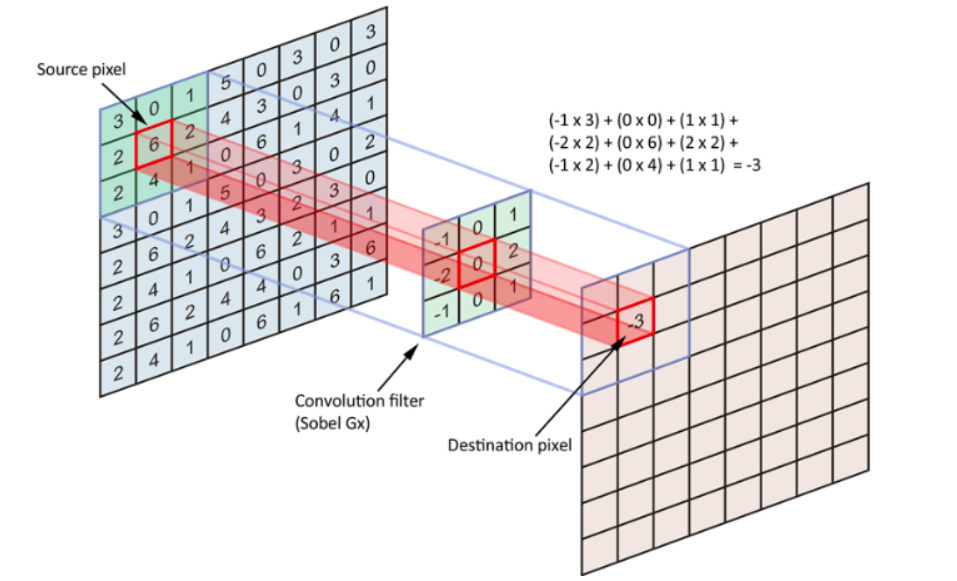

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 75)        300       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 75)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 50)        2

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20
215/215 [==============================] - 95s 435ms/step - loss: 1.0198 - accuracy: 0.6812 - val_loss: 3.9435 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 90s 417ms/step - loss: 0.1928 - accuracy: 0.9369 - val_loss: 0.7693 - val_accuracy: 0.7637 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 88s 408ms/step - loss: 0.0877 - accuracy: 0.9722 - val_loss: 0.0972 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 90s 416ms/step - loss: 0.0578 - accuracy: 0.9808 - val_loss: 0.0258 - val_accuracy: 0.9932 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 89s 413ms/step - loss: 0.0437 - accuracy: 0.9868 - val_loss: 0.0261 - val_accuracy: 0.9930 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9869
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [=============================

In [ ]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 5s 23ms/step - loss: 0.0032 - accuracy: 0.9986
Accuracy of the model is -  99.86056685447693 %


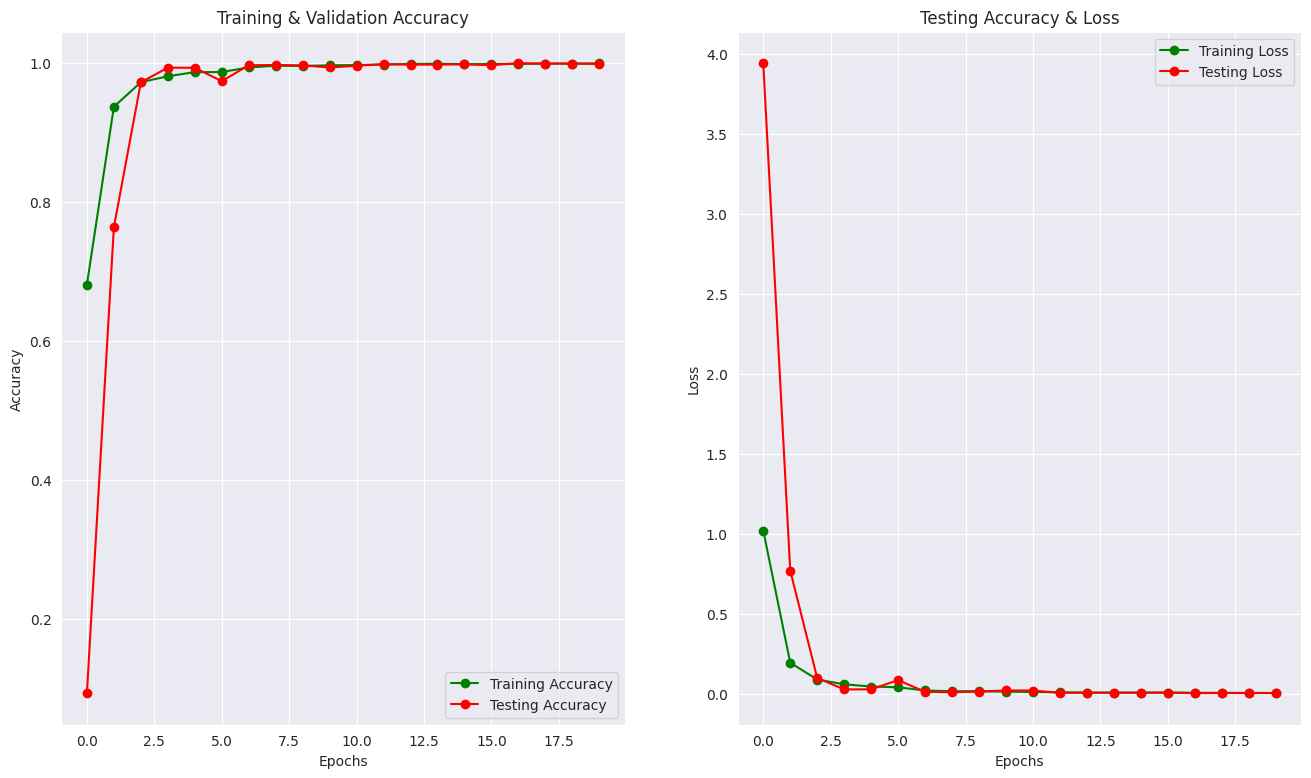

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
predictions = model.predict(x_test)  # Get probabilities for each class
predictions = predictions.argmax(axis=1)  # Convert probabilities to class predictions

for i in range(len(predictions)):
    if predictions[i] >= 9:
        predictions[i] += 1

print(predictions[:5])


225/225 [==============================] - 5s 22ms/step
[ 6  5 10  0  3]


In [ ]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      0.99      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       0.99      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       1.00    

In [ ]:
cm = confusion_matrix(y,predictions)

In [ ]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

<Axes: >

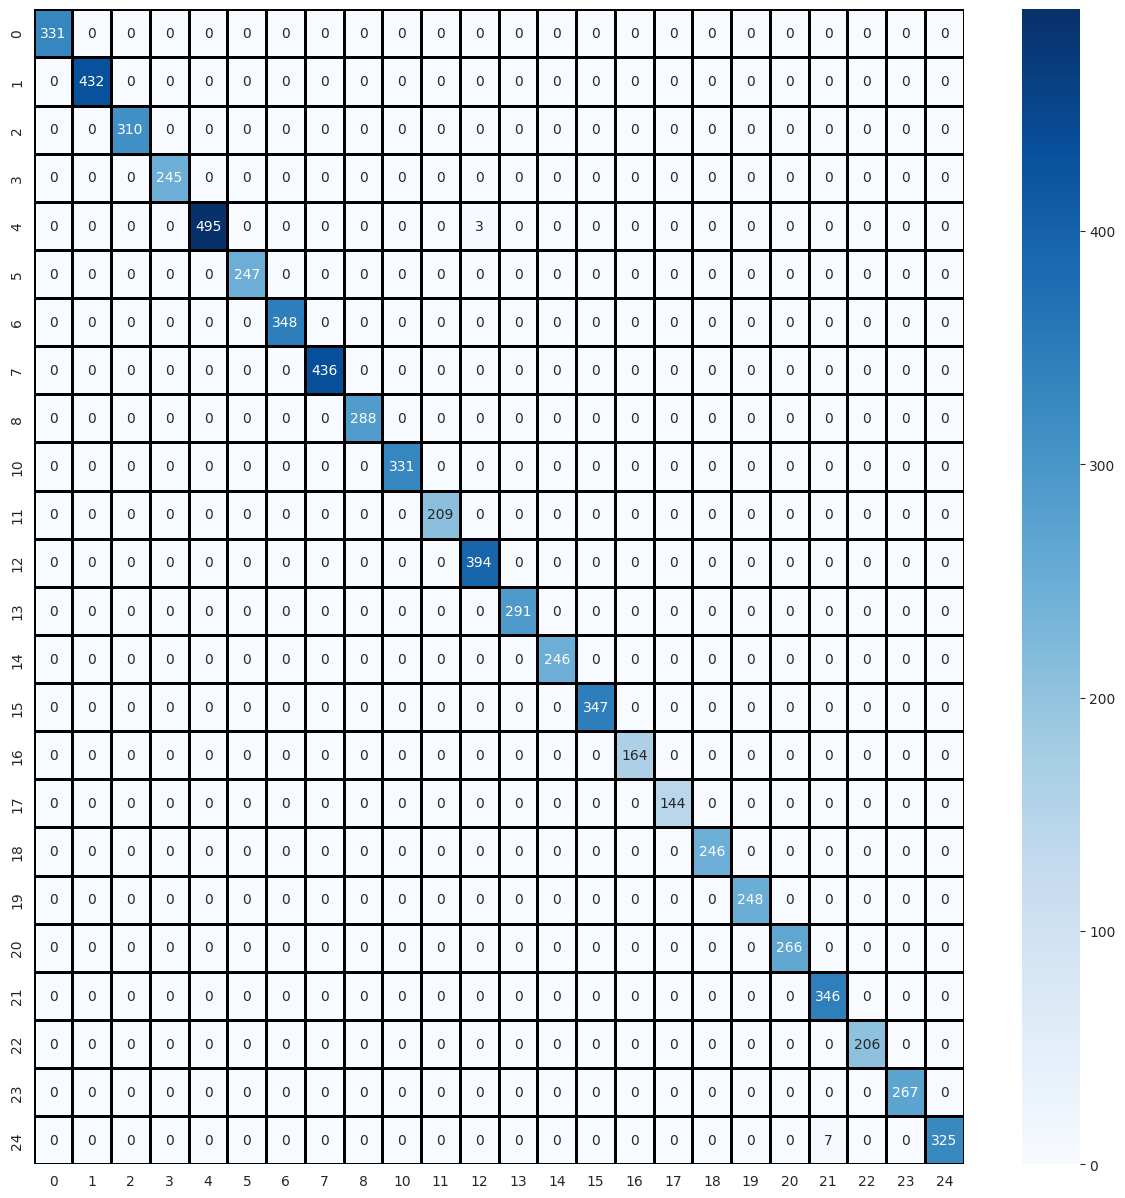

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
correct = np.nonzero(predictions == y)[0]

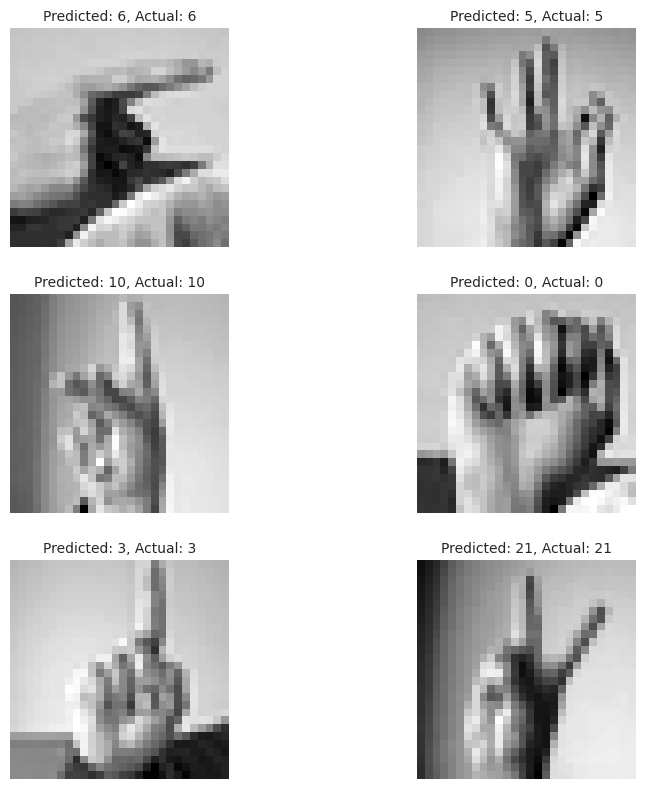

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
i = 0
for c in correct[:6]:
    plt.subplot(3, 2, i + 1)
    plt.imshow(x_test[c].reshape(28, 28), cmap="gray", interpolation="none")
    plt.title(f"Predicted: {predictions[c]}, Actual: {y[c]}", fontsize=10)
    plt.axis('off')
    i += 1
plt.tight_layout(h_pad=2.0)
plt.show()
